# Clip & Categorize Drought Measures

a. stein 9.9.2022

Following the work of `organize_data/clip_cat_spei.ipynb`, this notebook looks to clip and categorize the remaining drought measures since the workflow is fairly identical. I want to only use the ones that are weekly at sparsest. These are:
- grace (REMOVED FROM THIS NOTEBOOK)
- palmer z
- pdsi

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_129784/1988245056.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Load in USDM and eddi

In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

# USDM will be already clipped, but we'll need to clip spi real quick
usdm = xr.open_dataset(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc')

In [3]:
dms = ['palmer_z_index', 'pdsi']

In [4]:
dms_ds = [xr.open_dataset(f'{dm_path}/{dm}/{dm}.nc') for dm in dms]

In [5]:
dm_vars = []
dms_da = []

for ds in tqdm(dms_ds):
    for var in ds.var():
        dm_vars.append(var)
        dms_da.append(ds[var].rio.write_crs('EPSG:4326', inplace=True))

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
dms_da[0]

<xarray.DataArray 'z' (day: 3066, lat: 585, lon: 1386)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -67.14 -67.1 -67.06
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 25.19 25.15 25.11 25.07
  * day      (day) datetime64[ns] 1980-01-05 1980-01-10 ... 2021-12-31
    crs      int64 0
Attributes:
    units:              
    description:        Z Index
    long_name:          z
    standard_name:      z
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326

In [7]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)
wa_gdf = states_gdf[(states_gdf.NAME=='Washington')]

In [8]:
wa_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
dms_da_wa = []

for da in tqdm(dms_da):
    da = da.rename({'lon':'x', 'lat':'y'})
    da_wa = wrangle.clip_xarray(da, wa_gdf).rename({'x':'lon', 'y':'lat'})
    dms_da_wa.append(da_wa)

  0%|          | 0/2 [00:00<?, ?it/s]

Double check nothing went wrong in clipping ...

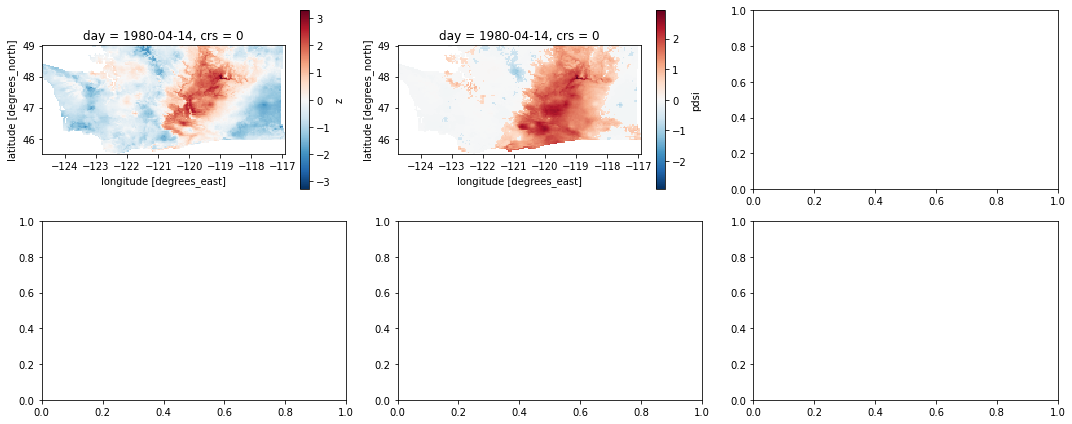

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(15,6))

i = 20

for ax, da in zip(axs.ravel(), dms_da_wa):

    # right, they're all on different time scales ...
    if 'day' in da.coords:
        da.isel(day=i).plot(ax=ax)

    elif 'time' in da.coords:
        da.isel(time=i).plot(ax=ax)

    ax.set_aspect('equal')

plt.tight_layout()

In [11]:
out_dms = ['palmer_z_index', 'pdsi']

In [12]:
for dm_var, da, out_dm in zip(dm_vars, dms_da_wa, out_dms):
    attrs = da.attrs
    attrs['Clipping'] = 'original data was clipped to Washington using http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
    
    try:
        del attrs['grid_mapping']
    except:
        pass
    
    da.attrs = attrs

    try:
        os.remove(f'{dm_path}/{out_dm}/WA/{dm_var}.nc')
    except:
        pass

    da.to_netcdf(f'{dm_path}/{out_dm}/WA/{dm_var}.nc')

### Convert to USDM categories

In [13]:
'time' in dms_da_wa[0].to_dataset().coords

False

In [14]:
dms_da_wa_cat = []

percentiles = [
    [-0.87, -1.5, -2, -2.75, -3.5],
    [-1, -2, -3, -4, -5]    
]

for da, percentile in zip(dms_da_wa, percentiles):
    dms_da_wa_cat.append(compare.dm_to_usdmcat_multtime(da, percentiles=percentile))

In [15]:
dms_da_wa_cat[0]

<xarray.DataArray 'z' (day: 3066, lat: 84, lon: 188)>
array([[[nan, nan, nan, ..., -1., nan, nan],
        [nan, nan, nan, ..., -1., nan, nan],
        [nan, nan, nan, ..., -1., nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., -1., nan, nan],
        [nan, nan, nan, ..., -1., nan, nan],
        [nan, nan, nan, ..., -1., nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., -1., nan, nan],
        [nan, nan, nan, ..., -1., nan, nan],
        [nan, nan, nan, ..., -1., nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., -1., nan, nan],
        [nan, nan, nan, ..., -1., nan, nan],
        [nan, nan, nan, ..., -1., nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., -1., nan, nan],
        [nan, nan, nan, ..., -1., nan, nan],
        [nan, nan, nan, ..., -1., nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * day      (day) datetime64[ns] 1980-01-05 1980-01-10 ... 2021-12-31
    crs      int64 0
Attributes:
    units:              
    description:        Z Index
    long_name:          z
    standard_name:      z
    dimensions:         lon lat time
    coordinate_system:  WGS84,EPSG:4326
    Clipping:           original data was clipped to Washington using http://...

Now for the pairing, this may get tricky to do in loop

In [16]:
usdm = xr.open_dataset(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc')

Will need to separate out into each dm

In [17]:
palmer_da = dms_da_wa_cat[0] # day
pdsi_da = dms_da_wa_cat[1] # day

Fab

In [18]:
usdm_dates = pd.DatetimeIndex(usdm['date'].values)
palmer_dates = pd.DatetimeIndex(palmer_da['day'].values)
pdsi_dates = pd.DatetimeIndex(palmer_da['day'].values)

In [19]:
pair_dates = []



for dates, name in zip([palmer_dates, pdsi_dates], ['PALMER_Z', 'PDSI']):
    pair_dates.append(compare.pair_to_usdm_date(usdm_dates.copy(), dates, f'{name} Date', realign=True))

/pool0/data/steinjao/drought/drought_impact/notebooks/organize_data/../../ndrought/compare.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_dates['USDM Date'].iloc[i-1] = date
/pool0/data/steinjao/drought/drought_impact/notebooks/organize_data/../../ndrought/compare.py:128: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  pair_dates = pair_dates.dropna('index')
/pool0/data/steinjao/drought/drought_impact/notebooks/organize_data/../../ndrought/compare.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_dates['USDM Date'].iloc[i-1] = date
/pool0/data/

In [20]:
pair_dates

[     PALMER_Z Date            USDM Date
 0       1999-12-31  2000-01-04 00:00:00
 1       2000-01-10  2000-01-11 00:00:00
 2       2000-01-15  2000-01-18 00:00:00
 3       2000-01-25  2000-01-25 00:00:00
 4       2000-01-30  2000-02-01 00:00:00
 ...            ...                  ...
 1144    2021-12-06  2021-12-07 00:00:00
 1145    2021-12-11  2021-12-14 00:00:00
 1146    2021-12-21  2021-12-21 00:00:00
 1147    2021-12-26  2021-12-28 00:00:00
 1148    2021-12-31  2022-01-04 00:00:00
 
 [1149 rows x 2 columns],
       PDSI Date            USDM Date
 0    1999-12-31  2000-01-04 00:00:00
 1    2000-01-10  2000-01-11 00:00:00
 2    2000-01-15  2000-01-18 00:00:00
 3    2000-01-25  2000-01-25 00:00:00
 4    2000-01-30  2000-02-01 00:00:00
 ...         ...                  ...
 1144 2021-12-06  2021-12-07 00:00:00
 1145 2021-12-11  2021-12-14 00:00:00
 1146 2021-12-21  2021-12-21 00:00:00
 1147 2021-12-26  2021-12-28 00:00:00
 1148 2021-12-31  2022-01-04 00:00:00
 
 [1149 rows x 2 column

In [21]:
palmer_da = palmer_da.sel(day=pair_dates[0]['PALMER_Z Date'].values)

In [22]:
pdsi_da = pdsi_da.sel(day=pair_dates[1]['PDSI Date'].values)

In [23]:
palmer_usdmcat_ds = palmer_da.copy().to_dataset()
palmer_usdmcat_ds = palmer_usdmcat_ds.rename_vars({'z':'palmer_z'})
palmer_usdmcat_ds

<xarray.Dataset>
Dimensions:   (lat: 84, lon: 188, day: 1149)
Coordinates:
  * lat       (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon       (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * day       (day) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-31
    crs       int64 0
Data variables:
    palmer_z  (day, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [24]:
palmer_usdmcat_ds.attrs = {
    'author' : 'a. stein, 7/28/2022',
    'description' : 'Palmer Z Index gathered from various time windows, (specified by the value following the underscore), categorized into USDM categories ndrought.compare.dm_to_usdmcat function.',
    'clipping' : 'Clipped to Washington state using http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
}
palmer_usdmcat_ds

<xarray.Dataset>
Dimensions:   (lat: 84, lon: 188, day: 1149)
Coordinates:
  * lat       (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon       (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * day       (day) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-31
    crs       int64 0
Data variables:
    palmer_z  (day, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    author:       a. stein, 7/28/2022
    description:  Palmer Z Index gathered from various time windows, (specifi...
    clipping:     Clipped to Washington state using http://eric.clst.org/asse...

In [25]:
pdsi_usdmcat_ds = pdsi_da.copy().to_dataset()
pdsi_usdmcat_ds

<xarray.Dataset>
Dimensions:  (lat: 84, lon: 188, day: 1149)
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * day      (day) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-31
    crs      int64 0
Data variables:
    pdsi     (day, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

In [26]:
pdsi_usdmcat_ds.attrs = {
    'author' : 'a. stein, 7/28/2022',
    'description' : 'Palmer Drought Severity Index (PDSI) gathered from various time windows, (specified by the value following the underscore), categorized into USDM categories ndrought.compare.dm_to_usdmcat function.',
    'clipping' : 'Clipped to Washington state using http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
}
pdsi_usdmcat_ds

<xarray.Dataset>
Dimensions:  (lat: 84, lon: 188, day: 1149)
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * day      (day) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-31
    crs      int64 0
Data variables:
    pdsi     (day, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    author:       a. stein, 7/28/2022
    description:  Palmer Drought Severity Index (PDSI) gathered from various ...
    clipping:     Clipped to Washington state using http://eric.clst.org/asse...

In [27]:
usdm_da = usdm['USDM'].rio.write_crs('EPSG:4326', inplace=True)
usdm_da_upscaled = []

for data in [palmer_da, pdsi_da]:
    usdm_da_upscaled.append(usdm_da.copy().rio.reproject_match(data.rio.write_crs('EPSG:4326'), inplace=True))

In [28]:
timeless_dss = []

for i, ds in enumerate(usdm_da_upscaled):
    timeless_ds = ds.sel(date=pair_dates[i]['USDM Date'].values).to_dataset()
    timeless_ds['date'] = pair_dates[i].index.values
    timeless_ds = timeless_ds.rename_dims({'date':'index', 'x':'lon', 'y':'lat'})
    timeless_ds = timeless_ds.rename_vars({'date':'index', 'x':'lon', 'y':'lat'})
    timeless_ds['USDM Date'] = xr.DataArray(
        pair_dates[i]['USDM Date'].values, 
        dims=['index'], 
        coords=dict(index=pair_dates[i].index.values)
    )
    timeless_dss.append(timeless_ds)


In [29]:
palmer_timeless_ds = timeless_dss[0]
pdsi_timeless_ds = timeless_dss[1]

In [30]:
palmer_z = palmer_usdmcat_ds['palmer_z']
palmer_timeless_ds['palmer_z'] = xr.DataArray(
    palmer_z.values,
    dims=['index', 'lat', 'lon'],
    coords=dict(
        index=palmer_timeless_ds['index'].values,
        lat = palmer_z['lat'].values,
        lon = palmer_z['lon'].values
    )
)

palmer_timeless_ds['PALMER_Z Date'] = xr.DataArray(
    pair_dates[0]['PALMER_Z Date'].values,
    dims=['index'],
    coords=dict(index=pair_dates[1].index.values)
)

palmer_timeless_ds.attrs = {
    'author': 'a. stein 7/19/2022',
    'description': 'USDM and Palmer Z Index matched to USDM data cutoff dates, as described by the index for Washington State. USDM has been upscaled to Palmer Z Index resolution while Palmer Z Index has been categorized according to the USDM drought categories.',
    'USDM Date': 'this contains the original dates for USDM',
    'PALMER_Z Date': 'this contains the original dates for Palmer Z Index'
}

palmer_timeless_ds

<xarray.Dataset>
Dimensions:        (lat: 84, lon: 188, index: 1149)
Coordinates:
  * lat            (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon            (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index          (index) int64 0 1 2 3 4 5 6 ... 1143 1144 1145 1146 1147 1148
    spatial_ref    int64 0
Data variables:
    USDM           (index, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    USDM Date      (index) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-01-04
    palmer_z       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    PALMER_Z Date  (index) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-31
Attributes:
    author:         a. stein 7/19/2022
    description:    USDM and Palmer Z Index matched to USDM data cutoff dates...
    USDM Date:      this contains the original dates for USDM
    PALMER_Z Date:  this contains the original dates for Palmer Z Index

In [31]:
try:
    os.remove(f'{dm_path}/ndrought_products/paired_USDM_palmer_z.nc')
except:
    pass
palmer_timeless_ds.to_netcdf(f'{dm_path}/ndrought_products/paired_USDM_palmer_z.nc')

In [32]:
pdsi = pdsi_usdmcat_ds['pdsi']
pdsi_timeless_ds['pdsi'] = xr.DataArray(
    pdsi.values,
    dims=['index', 'lat', 'lon'],
    coords=dict(
        index=pdsi_timeless_ds['index'].values,
        lat = pdsi['lat'].values,
        lon = pdsi['lon'].values
    )
)

pdsi_timeless_ds['PDSI Date'] = xr.DataArray(
    pair_dates[1]['PDSI Date'].values,
    dims=['index'],
    coords=dict(index=pair_dates[1].index.values)
)

pdsi_timeless_ds.attrs = {
    'author': 'a. stein 7/19/2022',
    'description': 'USDM and PDSI matched to USDM data cutoff dates, as described by the index for Washington State. USDM has been upscaled to PDSI resolution while PDSI has been categorized according to the USDM drought categories.',
    'USDM Date': 'this contains the original dates for USDM',
    'PDSI Date': 'this contains the original dates for PDSI'
}

pdsi_timeless_ds

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1149)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1143 1144 1145 1146 1147 1148
    spatial_ref  int64 0
Data variables:
    USDM         (index, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    USDM Date    (index) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-01-04
    pdsi         (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    PDSI Date    (index) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-31
Attributes:
    author:       a. stein 7/19/2022
    description:  USDM and PDSI matched to USDM data cutoff dates, as describ...
    USDM Date:    this contains the original dates for USDM
    PDSI Date:    this contains the original dates for PDSI

In [33]:
try:
    os.remove(f'{dm_path}/ndrought_products/paired_USDM_pdsi.nc')
except:
    pass
pdsi_timeless_ds.to_netcdf(f'{dm_path}/ndrought_products/paired_USDM_pdsi.nc')

Phew, done. 